<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/Attention_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 645kB 9.8MB/s 
     |████████████████████████████████| 890kB 48.8MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 
     |████████████████████████████████| 3.8MB 50.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=471dd23225f349e5d483451adbd52a28e67ef011f8ad44f26a8cfaa65da93d56
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Imports

In [0]:
import torch
import torchtext
import random
import re
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from torchtext.vocab import GloVe
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel

In [3]:
print(torch.__version__)

1.5.0+cu101


# Arguments

In [0]:
args = {
    "bert_tokenizer": "bert-base-uncased",
    "bert_pretrained_model": "bert-base-uncased",
    "distilbert_tokenizer": "distilbert-base-uncased",
    "distilbert_pretrained_model": "distilbert-base-uncased",
    "seed": 1234,
    "bert_embedding_dim": 768,
    "use_glove": False,
    "glove_embedding_dim": 300,
    "max_vocab_size": 20000,
    "batch_size": 10,
    "output_dim": 11,
    "hidden_size": 256,
    "num_layers": 2,
    "dropout": 0.3,
    "fc_dropout": 0.5,
    "embed_dropout": 0.3,
    "weight_decay": 1e-5,
    "lr": 0.001,
    "epochs": 10
}

# Text pre-processor

In [0]:
def preprocessor(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = (re.sub('[\W]+', ' ', text.lower()) +
          ' '.join(emoticons).replace('-', '')) 
  return text.split()

In [6]:
og_text = '#Good music I love that #shit.'
processed = preprocessor(og_text)
processed

['good', 'music', 'i', 'love', 'that', 'shit']

# Setup Bert Tokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained(args['bert_tokenizer'])

In [9]:
max_input_length = tokenizer.max_model_input_sizes[args['bert_tokenizer']]

print(max_input_length)

512


In [0]:
def tokenize(tweet):
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

# Load and Generate Data

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')

random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True

if args['use_glove']:
  TEXT = data.Field(batch_first=True,
                    tokenize=preprocessor,
                    use_vocab=True,
                    sequential=True)
else:
  TEXT = data.Field(batch_first = True,
                use_vocab = False,
                tokenize = tokenize,
                preprocessing = tokenizer.convert_tokens_to_ids,
                init_token = tokenizer.cls_token_id,
                eos_token = tokenizer.sep_token_id,
                pad_token = tokenizer.pad_token_id,
                unk_token = tokenizer.unk_token_id)
  
LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = args['batch_size'],
    device = device
)

In [0]:
if args['use_glove']:
  TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300), 
                   max_size=args['max_vocab_size'])
  print(f"\nUnique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

# Batch Wrapper

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

# Build the Model

Load the pretrained bert model from the HuggingFace transformers library.

https://github.com/huggingface/transformers

In [15]:
bert = BertModel.from_pretrained(args['bert_pretrained_model'])

Use model architecture proposed at: https://www.aclweb.org/anthology/P16-2034/

In [0]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()

    self.attention = nn.Linear(hidden_size, 1)

  def forward(self, H):
    M = torch.tanh(H)
    M = self.attention(M).squeeze(2)
    alpha = F.softmax(M, dim=1).unsqueeze(1)
    return alpha

class AttentionBiLSTM(nn.Module):
  def __init__(self, hidden_size, num_layers, dropout, fc_dropout, 
               emb_layer_dropout, num_classes):
    super(AttentionBiLSTM, self).__init__()

    self.hidden_size = hidden_size
    
    if args['use_glove']:
      embedding_dim = args['glove_embedding_dim']
      self.embedding = nn.Embedding(len(TEXT.vocab), embedding_dim)
    else:
      self.bert = bert
      embedding_dim = args['bert_embedding_dim']
    
    # embedding layer dropout
    self.emb_layer_dropout = nn.Dropout(emb_layer_dropout)

    # lstm layer
    self.lstm = nn.LSTM(embedding_dim, 
                        hidden_size, 
                        num_layers, 
                        dropout=(0 if num_layers==1 else dropout),
                        bidirectional=True,
                        batch_first=True)
    
    # penultimate layer
    self.fc = nn.Linear(hidden_size, num_classes)
    self.fc_dropout = nn.Dropout(fc_dropout)
    
    self.attention = Attention(hidden_size)
  
  def forward(self, text):
    if args['use_glove']:
      embedded = self.embedding(text)
    else:
      with torch.no_grad():
        embedded = self.bert(text)[0]

    embedded = self.emb_layer_dropout(embedded)
    y, _ = self.lstm(embedded)
    y = y[:,:,:self.hidden_size] + y[:,:,self.hidden_size:]
    alpha = self.attention(y)
    r = alpha.bmm(y).squeeze(1)
    h = torch.tanh(r)
    logits = self.fc(h)
    logits = self.fc_dropout(logits)
    return logits, alpha 

In [17]:
model = AttentionBiLSTM(
    hidden_size=args['hidden_size'],
    num_layers=args['num_layers'],
    dropout=args['dropout'],
    fc_dropout=args['fc_dropout'],
    emb_layer_dropout=args['embed_dropout'],
    num_classes=args['output_dim'],
)


model

AttentionBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Freeze the parameters which are a part of the Bert Transformers model. 

In [0]:
if args['use_glove'] is False:
  for name, param in model.named_parameters():                
      if name.startswith('bert'):
          param.requires_grad = False

Show the trainable parameters.

In [19]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l0_reverse
lstm.weight_hh_l0_reverse
lstm.bias_ih_l0_reverse
lstm.bias_hh_l0_reverse
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
lstm.weight_ih_l1_reverse
lstm.weight_hh_l1_reverse
lstm.bias_ih_l1_reverse
lstm.bias_hh_l1_reverse
fc.weight
fc.bias
attention.attention.weight
attention.attention.bias


# Train the Model

In [0]:
import torch.optim as optim 

In [0]:
optimizer = optim.Adam(model.parameters(), weight_decay=args['weight_decay'])
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We evaluate using the Jaccard index and the macro and micro F1's as there are more suitable for multi-label text classification problems.

In [0]:
from sklearn.metrics import f1_score, jaccard_score

In [0]:
def metricize(preds, y):
  f1_macro = f1_score(y, preds.round(), average='macro')
  f1_micro = f1_score(y, preds.round(), average='micro')
  jaccard = jaccard_score(y, preds.round(), average='samples')

  return {
      'f1_macro': f1_macro,
      'f1_micro': f1_micro,
      'jaccard': jaccard,
  }

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()

    predictions, _ = model(batch.Tweet)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0

  model.eval()

  preds_list = []
  labels_list = []

  with torch.no_grad():
    
    for batch in iterator:

      predictions, _ = model(batch.Tweet)
     
      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list)), preds_list, labels_list

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train the model for 10 epochs and record the training and validation loss. 

In [28]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_acc = []
valid_acc = []

for epoch in range(args['epochs']):

    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_metrics, _, _, = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        if args['use_glove']:
          torch.save(model.state_dict(), 'glove-lstm-model.pt')
        else:
          torch.save(model.state_dict(), 'bert-lstm-model.pt')
        
    train_jaccard = train_metrics['jaccard']
    train_micro = train_metrics['f1_micro']
    train_macro = train_metrics['f1_macro']

    valid_jaccard = valid_metrics['jaccard']
    valid_micro = valid_metrics['f1_micro']
    valid_macro = valid_metrics['f1_macro']

    train_acc.append(train_jaccard)
    valid_acc.append(valid_jaccard)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Jaccard: {train_jaccard*100:.2f}% | Train F1 Micro: {train_micro*100:.2f}% | Train F1 Macro: {train_macro*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Jaccard: {valid_jaccard*100:.2f}%  | Val. F1 Micro: {valid_micro*100:.2f}%  | Val. F1 Macro: {valid_macro*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.547 | Train Jaccard: 17.78% | Train F1 Micro: 29.09% | Train F1 Macro: 18.01%
	 Val. Loss: 0.391 | Val. Jaccard: 47.10%  | Val. F1 Micro: 59.97%  | Val. F1 Macro: 37.22%
Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 0.520 | Train Jaccard: 24.08% | Train F1 Micro: 37.03% | Train F1 Macro: 25.01%
	 Val. Loss: 0.388 | Val. Jaccard: 49.65%  | Val. F1 Micro: 62.32%  | Val. F1 Macro: 38.07%
Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 0.511 | Train Jaccard: 25.29% | Train F1 Micro: 38.56% | Train F1 Macro: 27.23%
	 Val. Loss: 0.379 | Val. Jaccard: 52.59%  | Val. F1 Micro: 64.68%  | Val. F1 Macro: 46.02%
Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 0.506 | Train Jaccard: 25.75% | Train F1 Micro: 39.18% | Train F1 Macro: 27.82%
	 Val. Loss: 0.366 | Val. Jaccard: 51.89%  | Val. F1 Micro: 64.42%  | Val. F1 Macro: 44.06%
Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 0.504 | Train Jaccard: 26.06% | Train F1 Micro: 39.83% | Train F1 Macro: 28.51%
	 Val. Loss:

# Visualize the training and validation loss 

In [0]:
import matplotlib.pyplot as plt

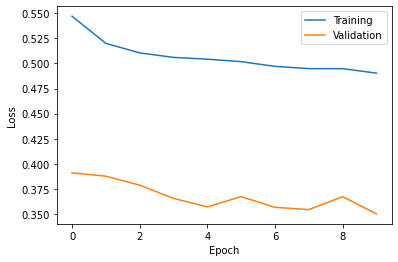

In [30]:
plt.plot(train_losses)
plt.plot(valid_losses)
# plt.title('Attention LSTM (GloVe) Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

# plt.savefig('attn-lstm-glove', dpi=300)

# Visualize the training and validation jaccard accuracy

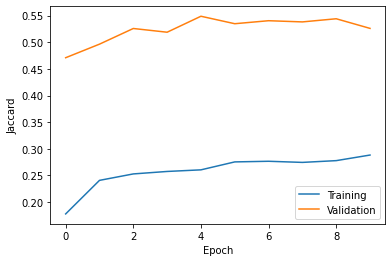

In [31]:
plt.plot(train_acc)
plt.plot(valid_acc)
# plt.title('Attention LSTM (GloVe) Training & Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Jaccard')
plt.legend(['Training', 'Validation'])
# plt.savefig('attn-lstm-acc-glove', dpi=300)

# Assess model performance on testing data

In [32]:
if (args['use_glove']):
  model.load_state_dict(torch.load('glove-lstm-model.pt'))
else:
  model.load_state_dict(torch.load('bert-lstm-model.pt'))


test_loss, test_metrics, preds_list, labels_list = evaluate(model, test_iterator, criterion)

test_jaccard = test_metrics['jaccard']
test_micro = test_metrics['f1_micro']
test_macro = test_metrics['f1_macro']

print(f'Test Loss: {test_loss:.3f} | Test Jaccard: {test_jaccard*100:.2f}% | Test F1 Micro: {test_micro*100:.2f}% | Test F1 Macro: {test_macro*100:.2f}%')

Test Loss: 0.349 | Test Jaccard: 52.61% | Test F1 Micro: 65.44% | Test F1 Macro: 48.57%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion matrix & Classification report

In [33]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

conf_matrix = multilabel_confusion_matrix(np.vstack(labels_list), np.vstack(preds_list).round())
print(conf_matrix)

cm = classification_report(np.vstack(labels_list), np.vstack(preds_list).round())
print(cm)

[[[1995  163]
  [ 386  715]]

 [[2823   11]
  [ 417    8]]

 [[1849  311]
  [ 299  800]]

 [[2714   60]
  [ 200  285]]

 [[1697  120]
  [ 425 1017]]

 [[2695   48]
  [ 346  170]]

 [[1806  310]
  [ 346  797]]

 [[2704  180]
  [ 251  124]]

 [[2008  291]
  [ 322  638]]

 [[3081    8]
  [ 162    8]]

 [[3081   25]
  [ 145    8]]]
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1101
           1       0.42      0.02      0.04       425
           2       0.72      0.73      0.72      1099
           3       0.83      0.59      0.69       485
           4       0.89      0.71      0.79      1442
           5       0.78      0.33      0.46       516
           6       0.72      0.70      0.71      1143
           7       0.41      0.33      0.37       375
           8       0.69      0.66      0.68       960
           9       0.50      0.05      0.09       170
          10       0.24      0.05      0.09       153

   micro avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()

  if args['use_glove']:
    tokenized = preprocessor(tweet)
    indexed = [TEXT.vocab.stoi[token] for token in tokenized]
  else:
    tokens = tokenizer.tokenize(tweet)
    tokens = tokens[:max_input_length-2]
    indexed = [tokenizer.cls_token_id] + tokenizer.convert_tokens_to_ids(tokens) + [tokenizer.sep_token_id]

  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions, attn_weights = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())

  if args['use_glove']:
    return preds, attn_weights, tokenized
  else:
    return preds, attn_weights, tokens

Lets test the model on our own input and save the attention weights and tokens for visualization. 

In [35]:
text = "Good music I love that shit"

preds, attn_weights, tokens = predict_emotion(model, tokenizer, text)

pred_values = []
for p in preds[0]:
  for val in p:
    pred_values.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {pred_values[i]}")

ANGER: 0.2750973701477051
ANTICIPATION: 0.09163666516542435
DISGUST: 0.23599089682102203
FEAR: 0.08520322293043137
JOY: 0.8124440312385559
LOVE: 0.5685871243476868
OPTIMISM: 0.4813237190246582
PESSIMISM: 0.07168387621641159
SADNESS: 0.1267954409122467
SURPRISE: 0.06157056242227554
TRUST: 0.21020734310150146


Here we format the attention weights and store the results in a dictionary

In [36]:
attention_weights = []
for aw in attn_weights[0]:
  for v in aw:
    attention_weights.append(v.detach().cpu().numpy())

if args['use_glove']:
  attention_weights = np.array(attention_weights)
else:
  attention_weights = attention_weights[1:-1]
  attention_weights = np.array(attention_weights)

attention_weights

array([0.11197709, 0.03706481, 0.02968199, 0.73123264, 0.03549661,
       0.04749265], dtype=float32)

In [37]:
attn_dict = {}
for i in range(len(attention_weights)):
  attn_dict[tokens[i]] = attention_weights[i]

print(attn_dict)

{'good': 0.111977085, 'music': 0.037064806, 'i': 0.029681988, 'love': 0.73123264, 'that': 0.035496615, 'shit': 0.047492653}


Lets return the top 3 words that the model focused on. 

In [0]:
from collections import Counter

In [39]:
weight_counter = Counter(attn_dict)
print(weight_counter)

Counter({'love': 0.73123264, 'good': 0.111977085, 'shit': 0.047492653, 'music': 0.037064806, 'that': 0.035496615, 'i': 0.029681988})


# Model performance on longer text

In [0]:
import os

In [41]:
text_1 = (
    "I'm only 24, and have worked part time jobs since I graduated from college." 
    " With everything going on, I've been furloughed from both of my part time jobs."
    " Well one offered me full time, and I was able to negotiate the salary up a full dollar per hour! And it has benefits and everything!" 
    " I know it's not a big deal but I'm just so excited and can't really tell anyone"
    " especially as I haven't spoken to my other part time job yet. Just hoping everything works out well, and that I have money for grad school in the fall!"
)

text_2 = (
    "I worked my ass off to graduate with my Bachelor's in 3 years."
    "My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'."
    "And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my"
    " professors snet me a graduation card. They were there for all of it. Still, not a single word about it."
    " I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements."
    " I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?"
    " I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back."
    " This really sucks."
)

preds, attn_weights, tokens = predict_emotion(model, tokenizer, text_2)

pred_values = []
for p in preds[0]:
  for val in p:
    pred_values.append(val)

# print(os.linesep.join(["I'm only 24, and have worked part time jobs since I graduated from college.", 
#                        "With everything going on, I've been furloughed from both of my part time jobs.",
#                        "Well one offered me full time, and I was able to negotiate the salary up a full dollar per hour!", 
#                        "And it has benefits and everything! I know it's not a big deal but I'm just so excited and", 
#                        "can't really tell anyone, especially as I haven't spoken to my other part time job yet.", 
#                        "Just hoping everything works out well, and that I have money for grad school in the fall!"]))

print(os.linesep.join(["I worked my ass off to graduate with my Bachelor's in 3 years.", 
                      "My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'.",
                      "And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my",
                      "professors snet me a graduation card. They were there for all of it. Still, not a single word about it.",
                      "I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements.",
                      "I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?",
                      "I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back.",
                      "This really sucks."]))

print()

print("Text length: 138 words")

print()
for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {pred_values[i]:.2f}")

I worked my ass off to graduate with my Bachelor's in 3 years.
My family hasn't said a word to me about it. No 'Congrats'! or 'I'm proud of you!'.
And it's not like they don't know. I live with them. I got my cap & gown in the mail last week and one my
professors snet me a graduation card. They were there for all of it. Still, not a single word about it.
I know this is a weird time, but I don't think that's an excuse to ignore your daughter's life achievements.
I feel so under-appreciated. I just want them to tell me they're proud. What kind of parent doesn't do that?
I'm 20 years old with a Bachelor of Science in Information Technology. I deserve a pat on the back.
This really sucks.

Text length: 138 words

ANGER: 0.32
ANTICIPATION: 0.15
DISGUST: 0.42
FEAR: 0.21
JOY: 0.30
LOVE: 0.13
OPTIMISM: 0.37
PESSIMISM: 0.38
SADNESS: 0.62
SURPRISE: 0.10
TRUST: 0.13
